<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar6/Adaboost2023_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U scikit-learn 
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install progressbar

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user instal

In [1]:
import math
import numpy as np
import pandas as pd


# Import helper functions
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn import datasets
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, mean_absolute_error, mean_squared_error, f1_score


random_state = 1

# Adaboost

## Boosting

The underlying idea of boosting is to combine **cheap weak**
predictiors into a strong **powerful ensemble**.

![](https://www.researchgate.net/profile/Eiji_Hato/publication/264713074/figure/fig5/AS:614118558023749@1523428682764/Concept-of-AdaBoost.png)

### AdaBoost pseudo code

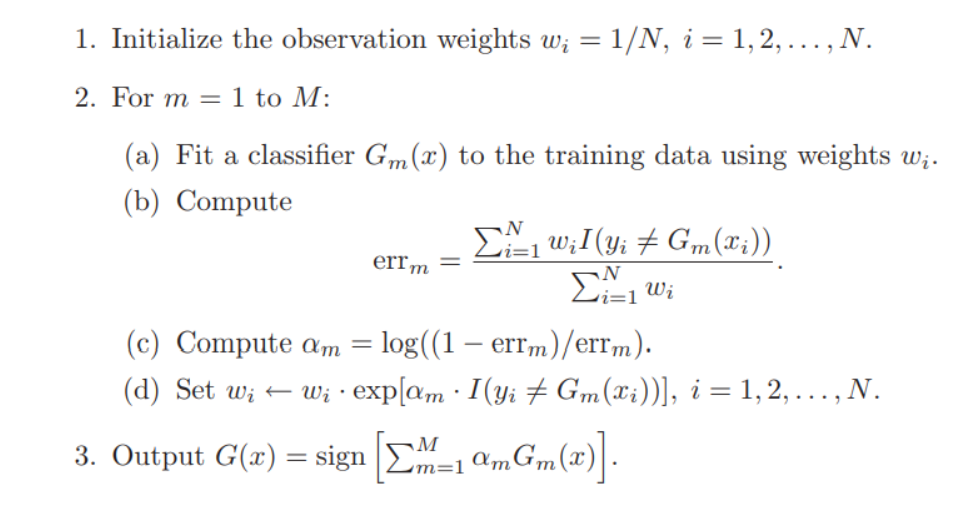

# AdaBoost a simple version

## Define one Stump

In [2]:
# Decision stump used as weak classifier in this impl. of Adaboost
class DecisionStump():
    def __init__(self):
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

In [3]:
class Adaboost():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    """
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        self.w = 0
        
        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_estimators):
            clf = DecisionStump()
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    error = sum(w[y != prediction])
                    
                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
                        
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            
            # TODO your code here, compute alpha Pseudo code step C:
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            # END of your code
            
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            
            
            # TODO your code here, update sample weights - Pseudo code step D
            w *= np.exp(-clf.alpha * y * predictions)
            # END of the code
            
            # Normalize to one
            w /= np.sum(w)
            
            self.w = w
            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred

## Some helper functions

In [4]:
def scikit_example(n_samples, random_state=None):
    X1, y1 = make_gaussian_quantiles(cov=2., n_samples=int(0.4*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                     n_samples=int(0.6*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    return np.concatenate((X1, X2)), np.concatenate((y1, 1 - y2))


def plot_adaboost(adaboost=None):
    mpl.style.use('seaborn')
    colors = ['blue', 'green' , 'red']

    ax = plt.figure(figsize=(12, 8)).add_subplot(111)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=mpl.colors.ListedColormap(colors))

    if adaboost:
        prob_ = adaboost.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm)
        ax.set_title("AdaBoost with %d trees"%(adaboost.n_estimators,));

## Let's check how it works

In [5]:
X, y = scikit_example(n_samples=1000, random_state=random_state)


## Set label values as inteded 

y[y == 0] = -1
y[y == 1] = 1

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=random_state)

min_, max_ = np.min(X, axis=0) - 1, np.max(X, axis=0) + 1
xx, yy = np.meshgrid(np.linspace(min_[0], max_[0], num=51),
                     np.linspace(min_[1], max_[1], num=51))


Accuracy: 0.596
Accuracy: 0.696
Accuracy: 0.726
Accuracy: 0.854


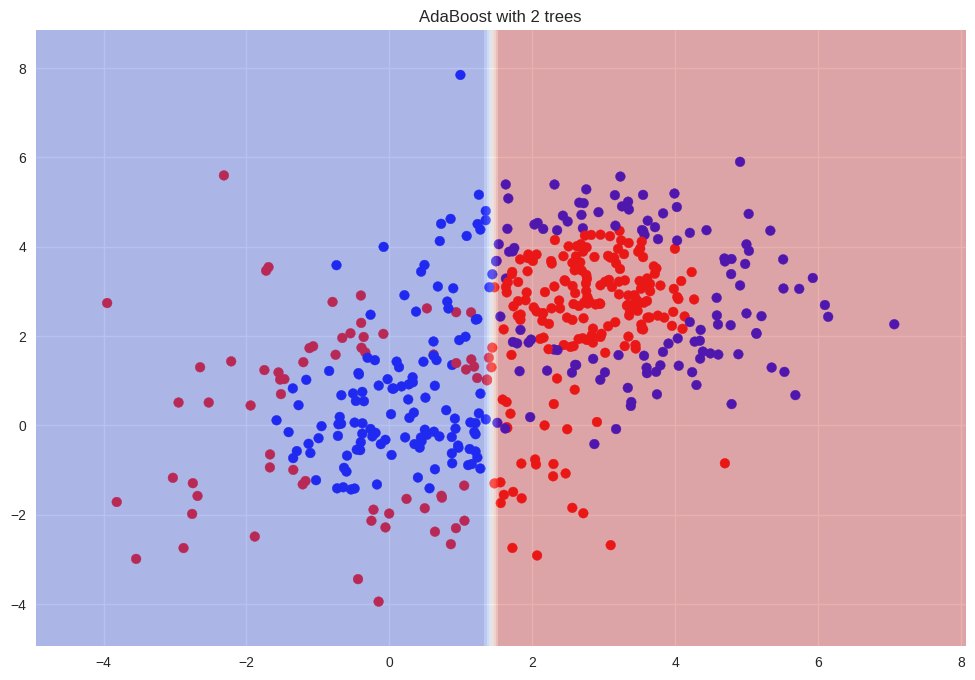

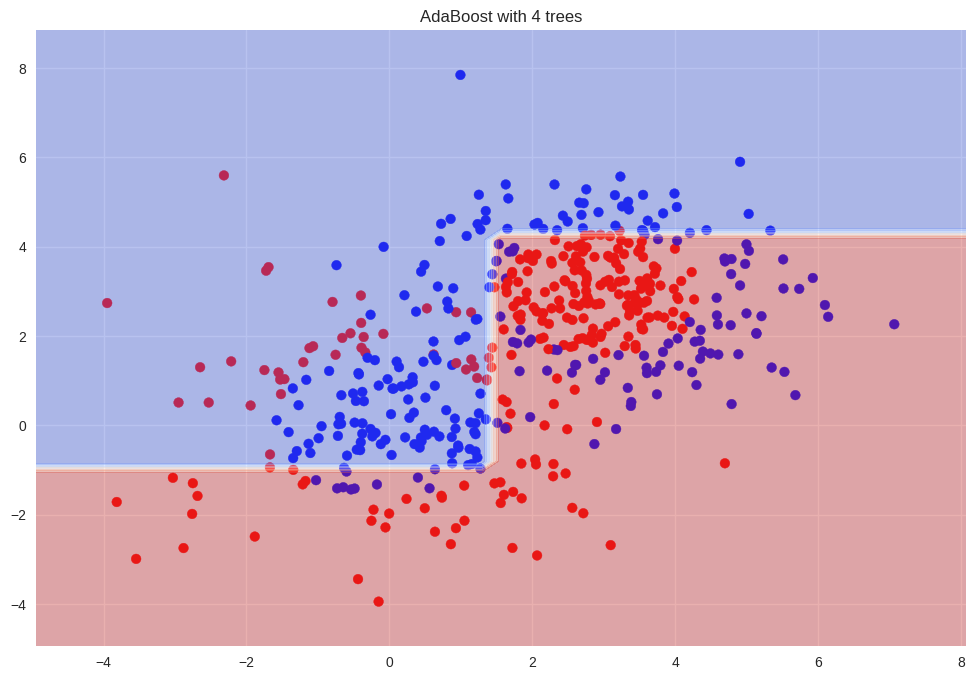

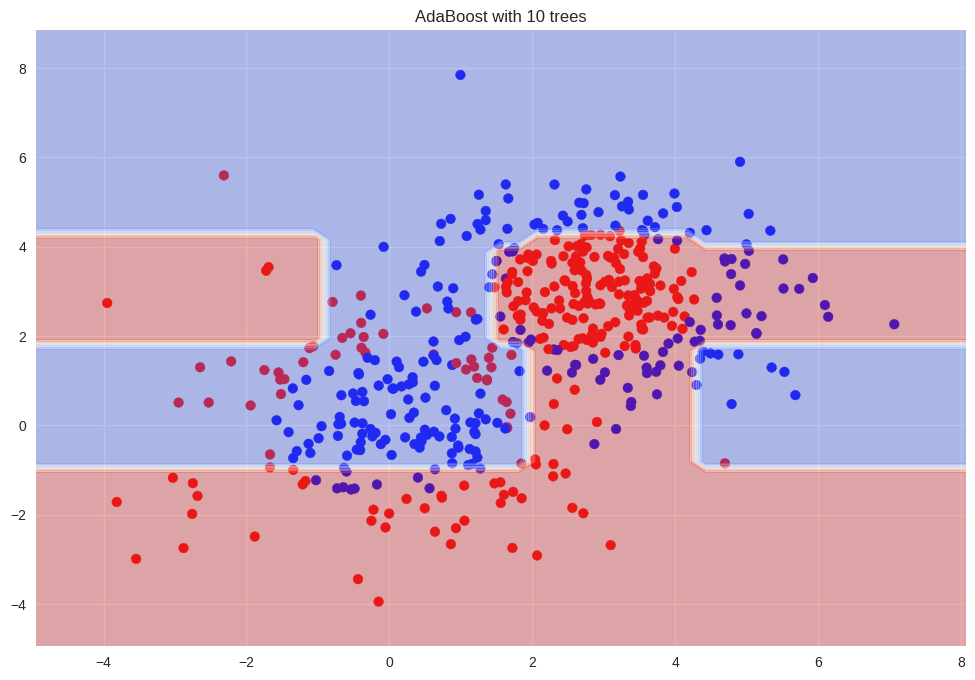

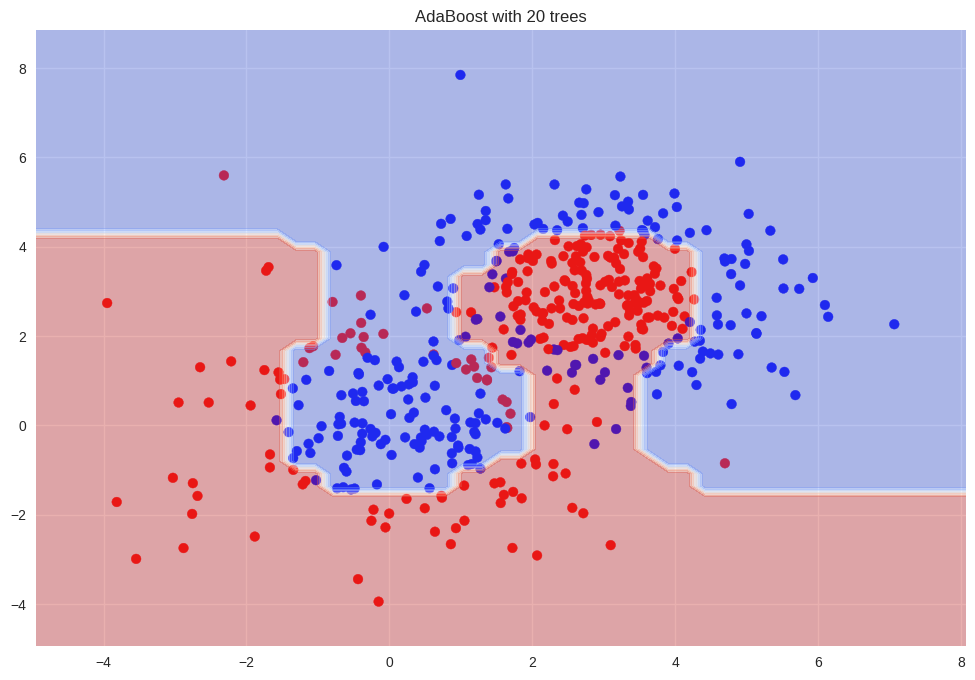

In [6]:
for n_tree in [2,4,10,20]:
    clf = Adaboost(n_estimators=n_tree)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print ("Accuracy:", accuracy)
    plot_adaboost(adaboost=clf)

# Let's see alpha weights for all the estimators

In [7]:
for t in clf.clfs:
    print(t.alpha)

0.27040322785309306
0.21140445335278485
0.2961667226765695
0.24927766711107208
0.26502164405208317
0.2844579041694503
0.251842960199161
0.19306517293941697
0.2482243330813013
0.23669018542636217
0.22110332315709702
0.2158134913739557
0.18801698149742507
0.20284482472573348
0.16999510893637493
0.18854778608387487
0.15991267635969206
0.1480323818061551
0.18113187062847147
0.1240254407289581


## Let's plot most important samples based on the last iteration

Text(0.5, 1.0, 'Most important samples')

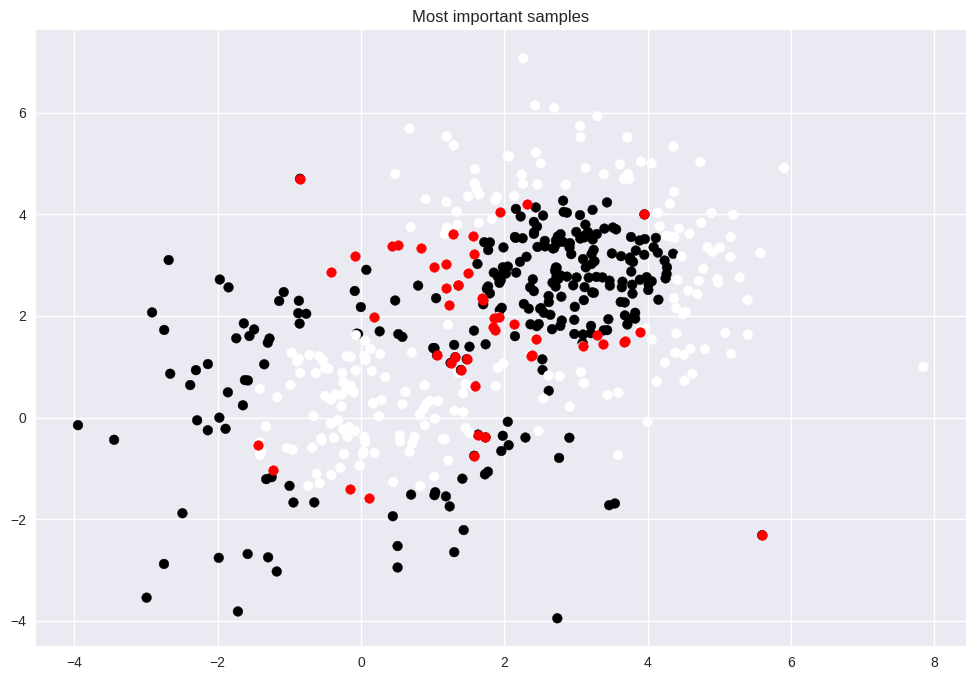

In [8]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)

plt.scatter(X_train[:,1], X_train[:,0], c=y_train)

# YOUR CODE HERE
idx = clf.w.argsort()[-50:]
# END OF YOUR CODE 


plt.scatter(X_train[idx][:,1], X_train[idx][:,0], c='r')
plt.title('Most important samples')

### It is clear that most important samples lie on class borders- Nice!

### AdaBoost in SciKit

The `ensemble` submodule implements both classification and regression
versions of Adaboost
* AdaBoostClassifier
* AdaBoostRegressor

Algorithms differ only in the **loss** used in determining the weight updates.

In [156]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

### Adaboost params

Common parameters:
- **n_estimators** -- the maximum size of the ensemble (in **case of a perfect fit** boosting stops earlier);
- **base_estimator** -- the base estimator of the ensemble, which must support **sample weighting**;
- **learning_rate** -- scales each update, slowing down convergence, but making it more accurate.

AdaBoostClassifier only:
- **algorithm** -- the AdaBoost version to use:
    * _"SAMME"_ -- the SAMME (**M1**) discrete boosting algorithm;
    * _"SAMME.R"_ -- the SAMME.R real boosting algorithm, typically achieves a lower test error with fewer boosting iterations than `SAMME`.
    
AdaBoostRegressor only:
- **loss** -- the loss function to use when updating the weights after each boosting iteration:
    * _"linear"_ -- absolute loss $L(y, p) = |y-p|$;
    * _"square"_ -- squared loss $L(y, p) = |y-p|^2$;
    * _"exponential"_ -- Exponential loss $L(y, p) = 1-e^{-|y-p|}$.

# Practice: toy example

In [158]:
X, y = scikit_example(n_samples=500, random_state=random_state)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=random_state)


min_, max_ = np.min(X, axis=0) - 1, np.max(X, axis=0) + 1
xx, yy = np.meshgrid(np.linspace(min_[0], max_[0], num=51),
                     np.linspace(min_[1], max_[1], num=51))

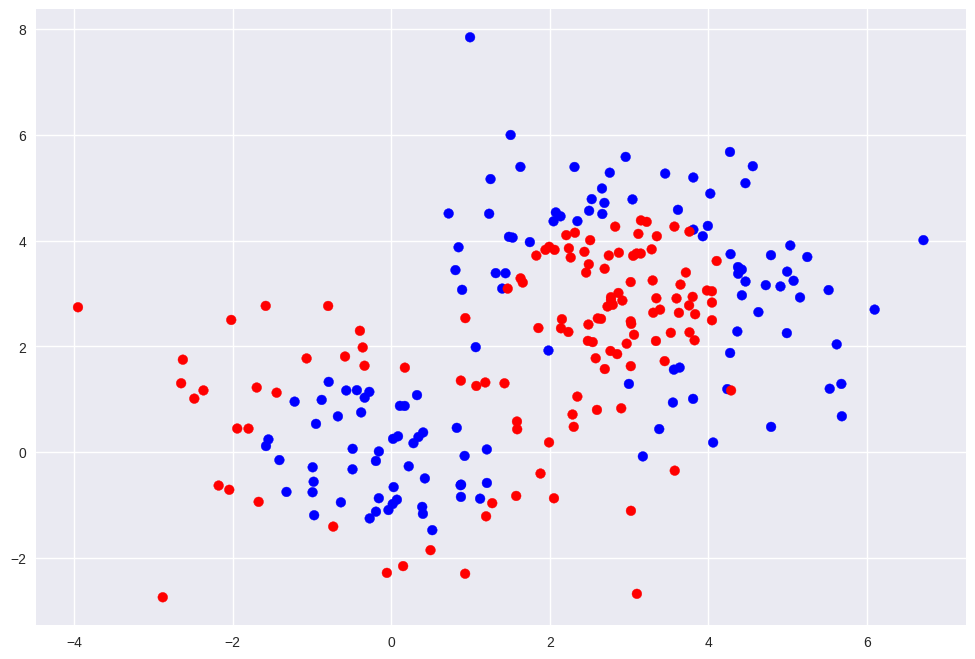

In [159]:
plot_adaboost()

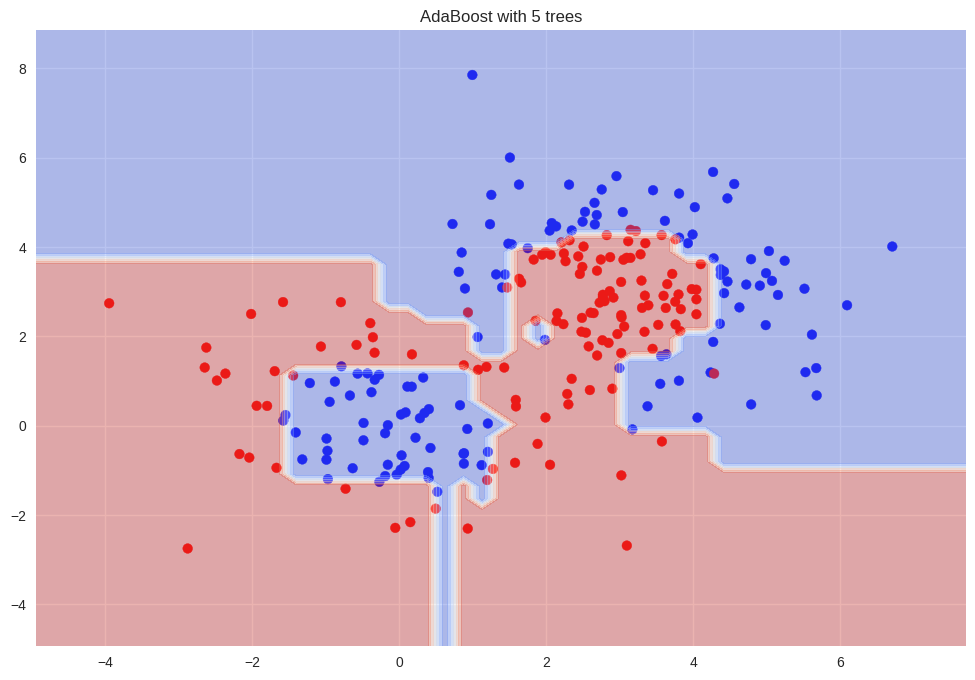

In [160]:
abc1_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=5, random_state=random_state)

abc1_.fit(X_train, y_train)


plot_adaboost(abc1_)

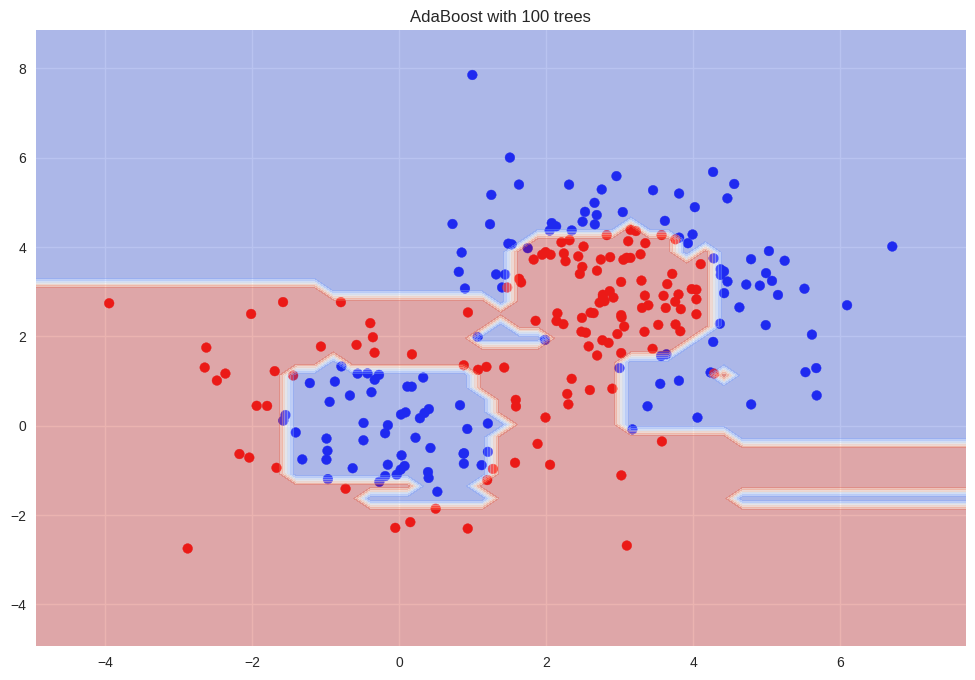

In [161]:
abc2_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=100, random_state=random_state)
abc2_.fit(X_train, y_train)

plot_adaboost(abc2_)

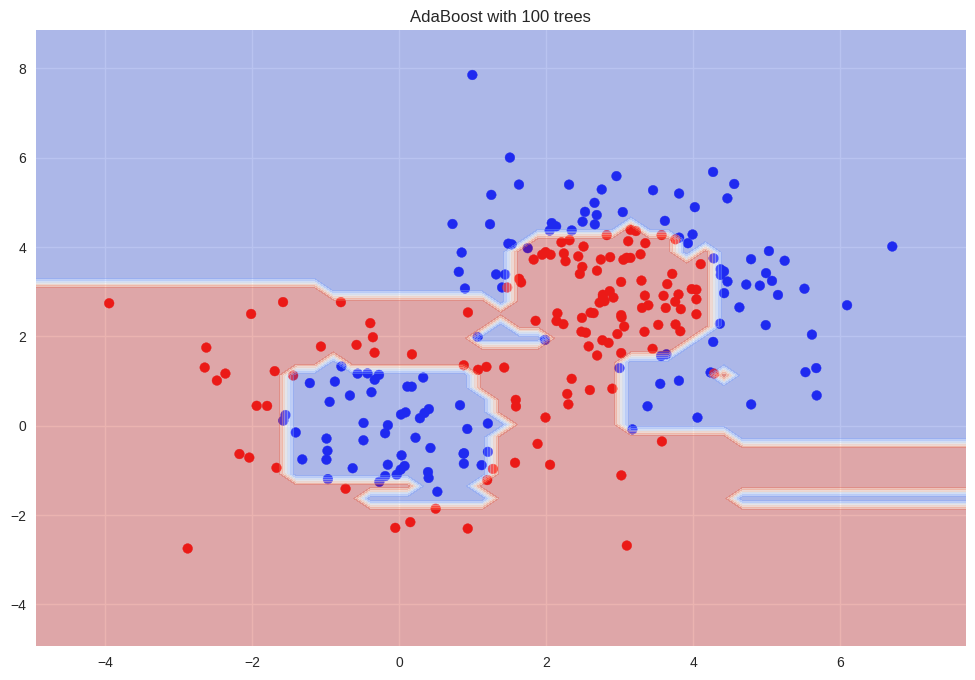

In [162]:
abc3_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=1000, random_state=random_state)
abc3_.fit(X_train, y_train)

plot_adaboost(abc2_)

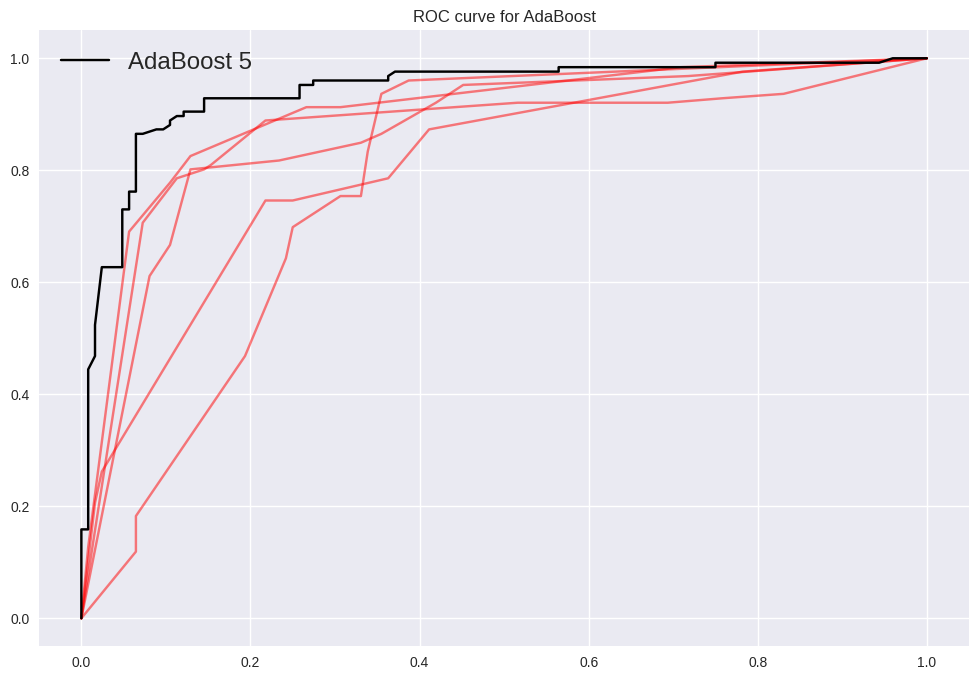

In [163]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc1_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.5)

fpr, tpr, _ = roc_curve(y_test, abc1_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc1_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

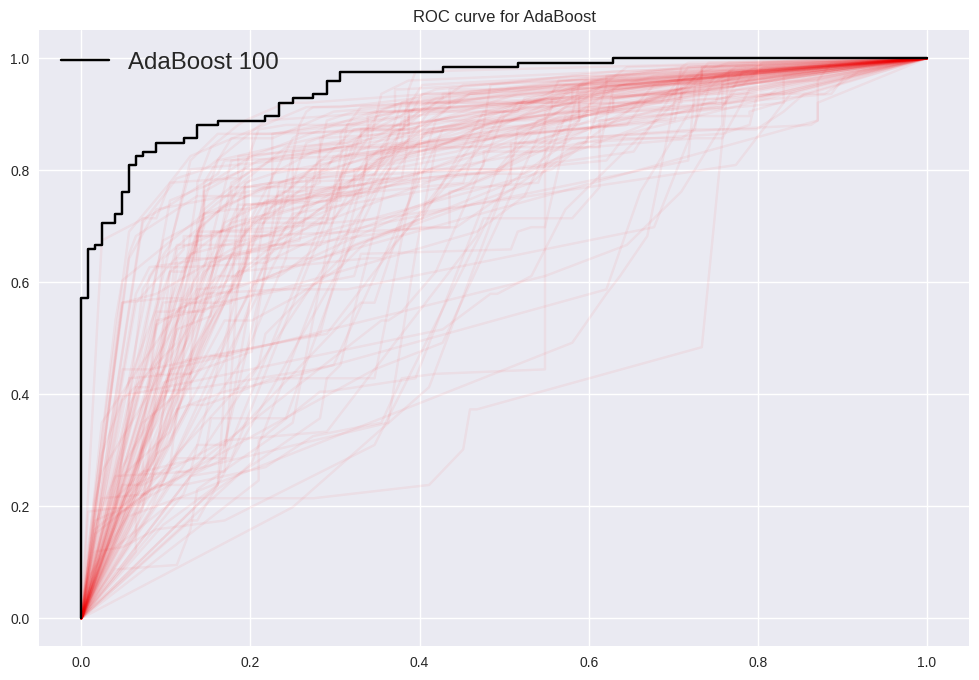

In [164]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc2_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, abc2_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc2_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

# Adult dataset


Download the dataset. If you use Windows, you can download it manually by the link [https://github.com/amueller/advanced_training/raw/master/data/adult.csv](https://github.com/amueller/advanced_training/raw/master/data/adult.csv)

In [283]:
!wget https://github.com/amueller/advanced_training/raw/master/data/adult.csv

--2023-02-10 12:43:30--  https://github.com/amueller/advanced_training/raw/master/data/adult.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amueller/advanced_training/master/data/adult.csv [following]
--2023-02-10 12:43:31--  https://raw.githubusercontent.com/amueller/advanced_training/master/data/adult.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3773638 (3.6M) [text/plain]
Saving to: ‘adult.csv.2’

adult.csv.2         100%[===================>]   3.60M  1.28MB/s    in 2.8s    

2023-02-10 12:43:34 (1.28 MB/s) - ‘adult.csv.2’ saved [3773638/3773638]



Let's look at it. We have some information about different persons. Our target value will be the income column. Since we have the information whether the income is above or below 50K, we will solve binary classification problem.

In [335]:
data = pd.read_csv('adult.csv', index_col=0)
print(data.shape)
data.head()

(32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [336]:
data.shape

(32561, 14)

## Let's conver our target income to binary value (0 and 1). 

In [337]:
if 'income' in data.columns:
    y = (data['income'] == ' >50K').values.astype(np.int32)
    del data['income']
    
del data['native-country']
    
y.shape

(32561,)

We have some categorical data in our dataset. Let us use one-hot-encoding for this columns. In order to automaticalli convert the data you should use method pd.get_dummies()

In [338]:
data = pd.get_dummies(data, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender'])
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,gender_ Female,gender_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,53,7,0,0,40,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,28,13,0,0,40,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [323]:
data.shape, y.shape

((32561, 65), (32561,))

In [324]:
X = data

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=9, stratify=y_test)

In [325]:
X_train.shape, X_val.shape, X_test.shape

((26048, 65), (3256, 65), (3257, 65))

In [291]:
def get_test_train_errors(_adaboost):
    train_errors = []

    for y in _adaboost.staged_predict(X_train):
        train_errors.append(f1_score(y_train, y))

    test_errors = []

    for y in _adaboost.staged_predict(X_val):
        test_errors.append(f1_score(y_val, y))
        
    print('F1 validation score:', f1_score(y_val, _adaboost.predict(X_val)))
    
    plt.figure(figsize=(12, 8))
    plt.plot(train_errors, label='train')
    plt.plot(test_errors, label='test')
    plt.legend(loc='best')

## F1 score

Since we consider binary classification, it is good to use some proper measure. One of them — F1

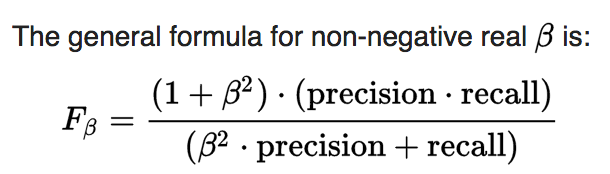

<br>

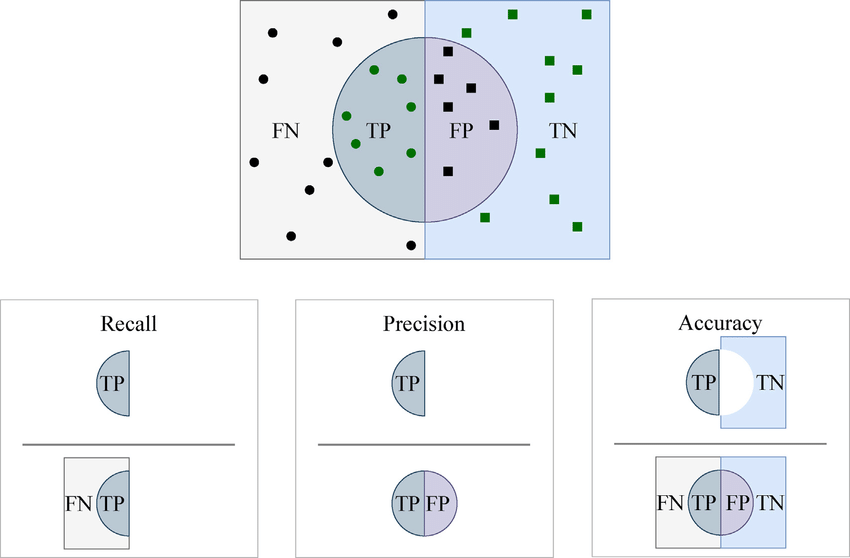

### Let's train AdaBoost with a lot of small trees

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.7037297677691766


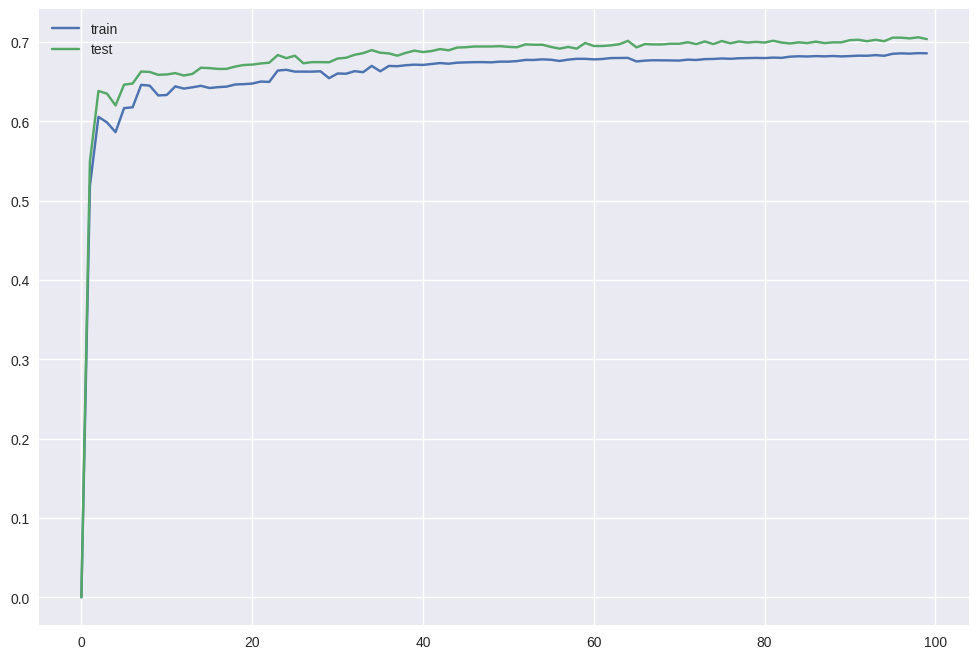

In [301]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

## Now, increase the depth of trees

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.6897009966777409


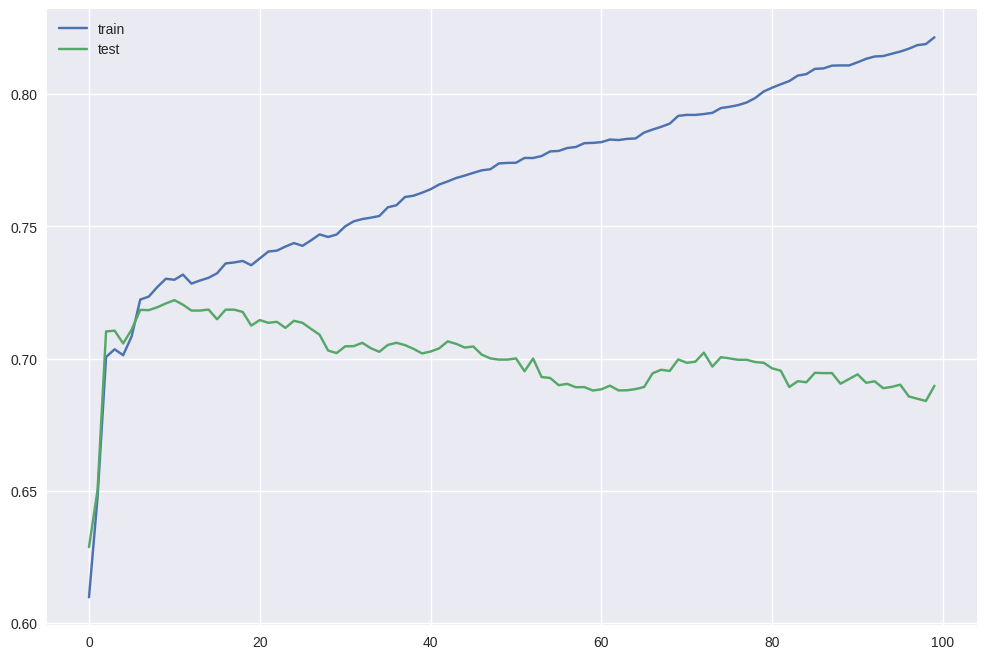

In [293]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

## Leave trees depth as 5, decrease n_estimators to 200

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.6798418972332017


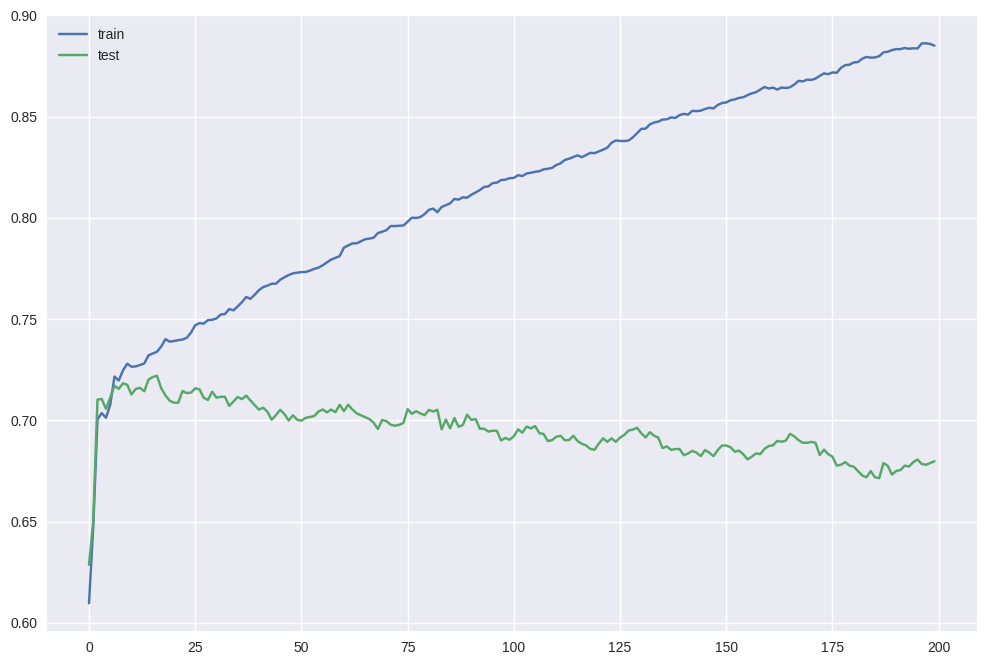

In [294]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=200)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

# Another example of overfitting
# Let's pertrube our dataset and loose all the structure within it

In [326]:
data_p = data.sample(frac=1).reset_index(drop=True)
data_p.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,gender_ Female,gender_ Male
0,44,10,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,32,5,0,0,50,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,34,12,0,0,25,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,41,10,0,0,40,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,12,0,0,40,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [327]:
X = data_p

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=10, stratify=y_test)

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.03182374541003672


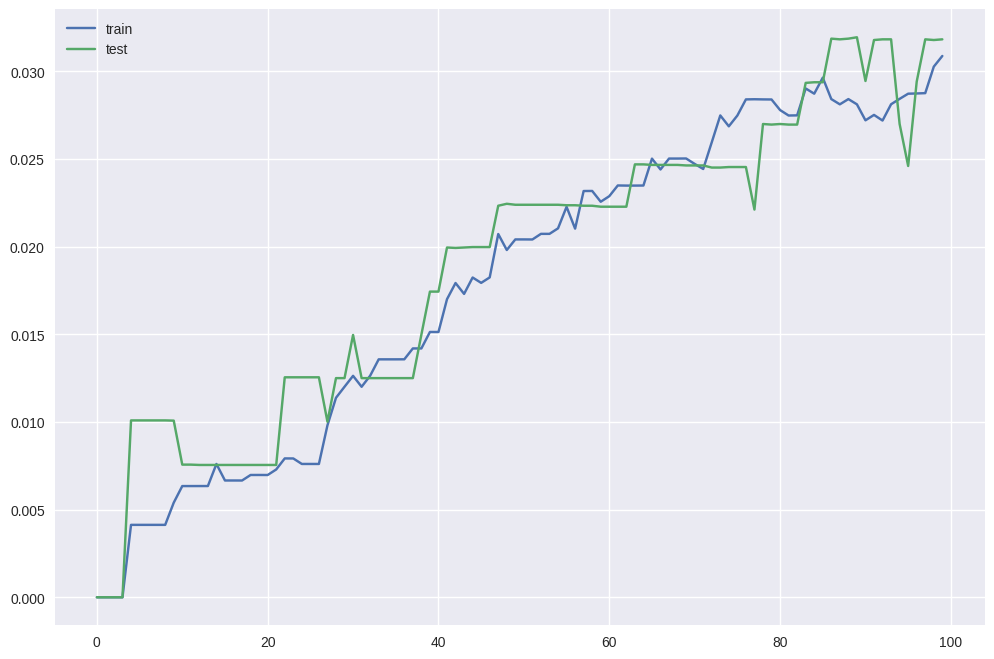

In [328]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.11553784860557768


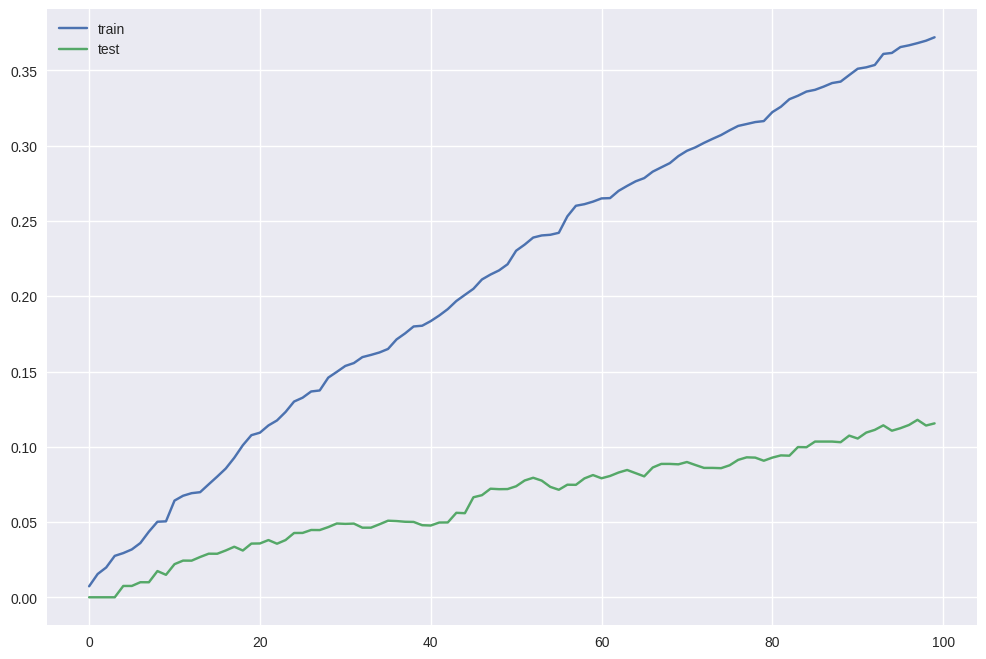

In [329]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.2210604929051531


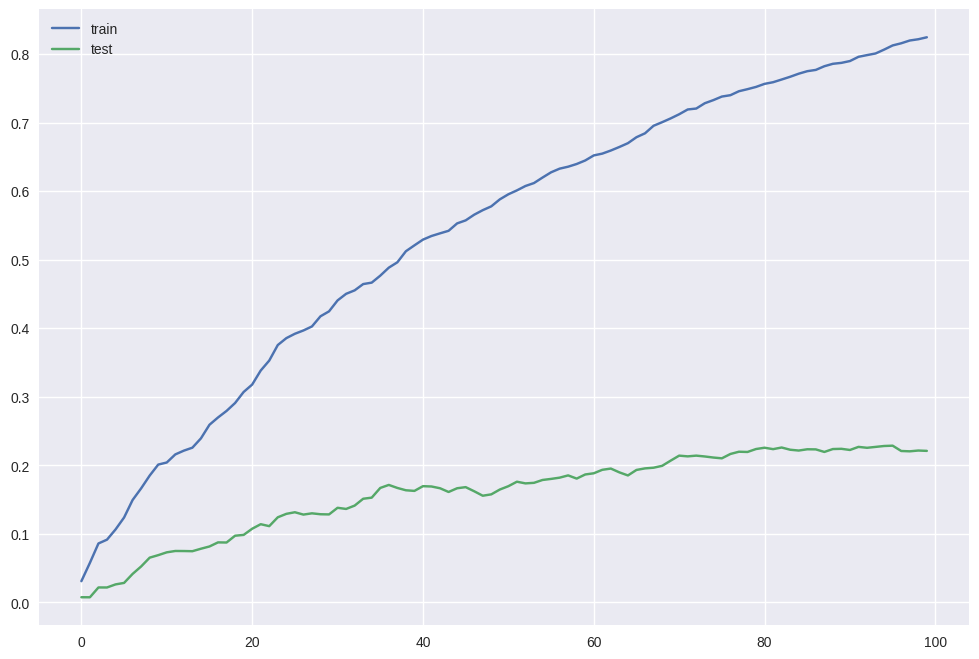

In [330]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=100)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

## Model is capable to learn some structure when there is no structure at all!

# Early stopping

### Ok, we understood, that we don't need too many trees because we overfit. But if we take not enough trees, we will underfit. 

### Here comes the regularization.

### And one of the best regularization methods (best in practice), that is applied to ensembles (and to NN) is early stopping.

## The idea behind it is simple: if our validation loss didn't increase last 'n_tolerance' steps, then we stop adding new trees.

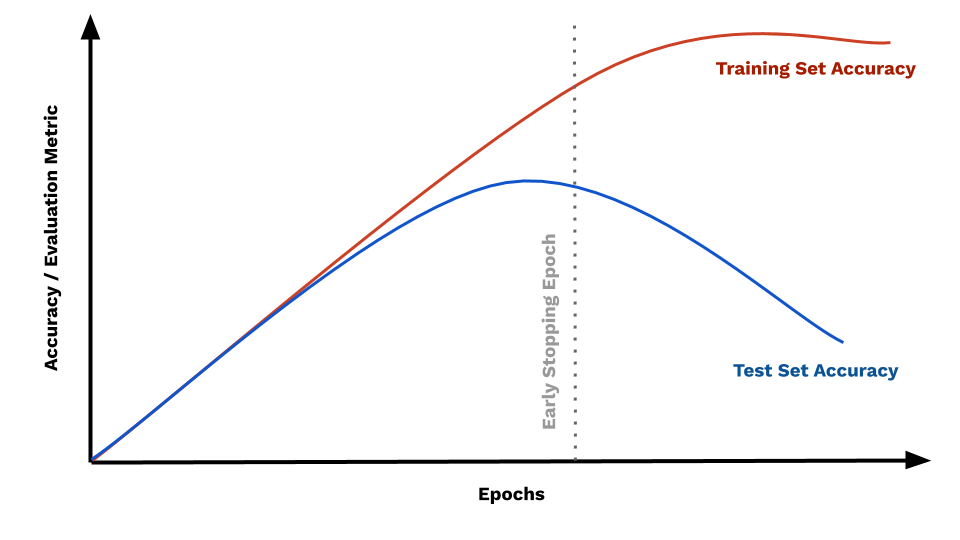


### Let's implement Early Stopping for adaboost algorithm. We will extend the class AdaBoostClassifier. In order to implement the Early Stopping, you should understand, that it is easier to cut the final algorithm (select only a number of first trees) instead of training it each time.

In [332]:
class EarlyStoppingAdaBoost(AdaBoostClassifier):
    def __init__(self, n_tolerance=10, score_func=accuracy_score, **kwargs):
        super().__init__(**kwargs)
        self.n_tolerance = n_tolerance
        self.score_func = score_func
        
    def fit(self, X_train, y_train, X_val, y_val):
        # train big AdaBoost
        super().fit(X_train, y_train)
        
        val_scores = [] # validation scores of subsets of trees
        wait = 1 # how much iterarations we have already waited for the increase of the score
        n_trees = 0 # number of trees to take after early stopping
        
        for y_pred in self.staged_predict(X_val):
            # stage predict allows to predict using only subset of trees 
            # i.e. on the first iteration with 1 tree, on the second with 2 trees

            # Now you have to write an early stopping algorithm
            ######################
            # YOUR CODE HERE!
            n_trees += 1
            current_val_score = self.score_func(y_val, y_pred)
            
            if len(val_scores) > 0 and current_val_score > np.max(val_scores[-self.n_tolerance:]):
                # validation loss increased
                wait = 1
            else:
                if wait > self.n_tolerance:
                    # last self.n_tolerance validation score didn't decrease
                    break
                else:
                    # validation score didn't increase, but let's wait
                    wait += 1
                    
            val_scores.append(current_val_score)
            # END OF YOUR CODE HERE!
            ######################
                    
        self.estimators_ = self.estimators_[:n_trees]
        
        return self

In [339]:
X = data

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=10, stratify=y_test)

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.7029569892473118


/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"


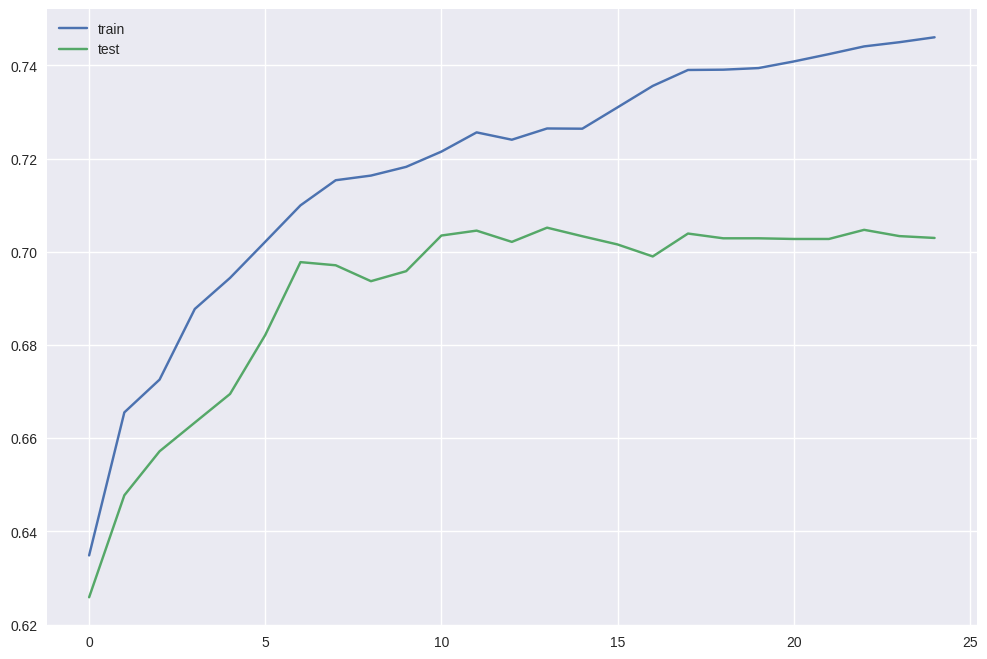

In [340]:
adaboost = EarlyStoppingAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=200,
                                 n_tolerance=10, score_func=f1_score)

adaboost.fit(X_train, y_train, X_val, y_val)

get_test_train_errors(adaboost)

/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"
/home/diff7/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but EarlyStoppingAdaBoost was fitted with feature names
  "X does not have valid feature names, but"


F1 validation score: 0.6765119549929677


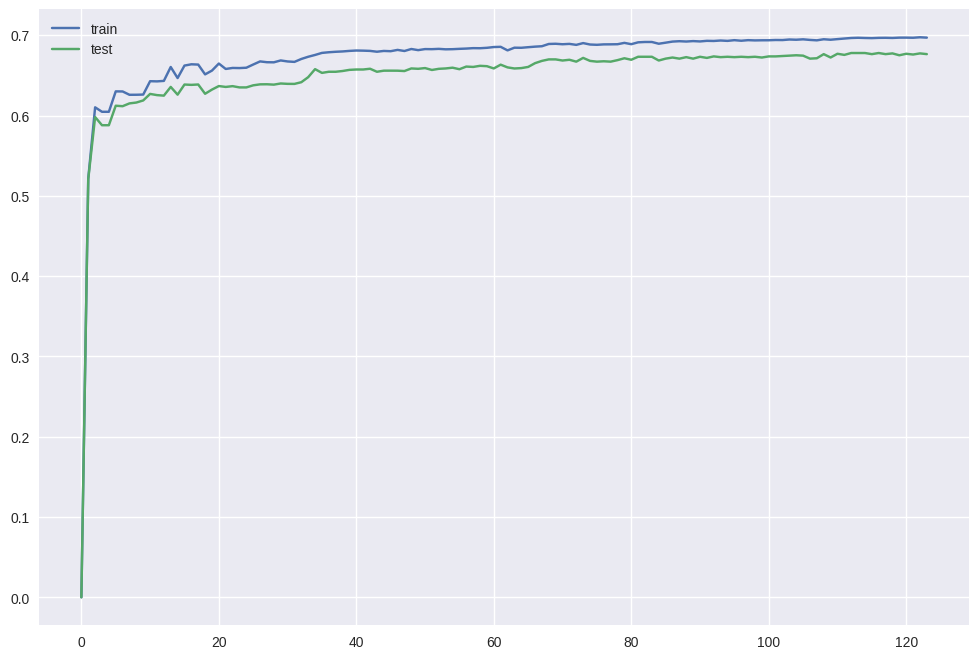

In [341]:
adaboost = EarlyStoppingAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=1000,
                                 n_tolerance=10, score_func=f1_score)
adaboost.fit(X_train, y_train, X_val, y_val)

get_test_train_errors(adaboost)

# Feature Importance: how?

In [32]:
importances = adaboost.feature_importances_
std = np.std([tree.feature_importances_ for tree in adaboost.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, data.columns[f], importances[indices[f]]))

Feature ranking:
1. feature age (0.004000)
2. feature education-num (0.003000)
3. feature capital-gain (0.003000)
4. feature capital-loss (0.003000)
5. feature hours-per-week (0.002000)
6. feature workclass_ Federal-gov (0.001000)
7. feature workclass_ Local-gov (0.001000)
8. feature workclass_ Private (0.001000)
9. feature workclass_ Self-emp-inc (0.001000)
10. feature workclass_ Self-emp-not-inc (0.001000)
11. feature workclass_ State-gov (0.001000)
12. feature workclass_ Without-pay (0.001000)
13. feature education_ 10th (0.001000)
14. feature education_ 11th (0.001000)
15. feature education_ 12th (0.001000)
16. feature education_ 1st-4th (0.001000)
17. feature education_ 5th-6th (0.000000)
18. feature education_ 7th-8th (0.000000)
19. feature education_ 9th (0.000000)
20. feature education_ Assoc-acdm (0.000000)
21. feature education_ Assoc-voc (0.000000)
22. feature education_ Bachelors (0.000000)
23. feature education_ Doctorate (0.000000)
24. feature education_ HS-grad (0.000000

In [33]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [34]:
clf1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=20)
clf2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                 n_estimators=50)

mix_clf_scores = []
for alpha in np.linspace(0., 1., 10):
    clf = VotingClassifier([('clf1', clf1), ('clf2', clf2)], voting='soft', weights=[alpha, 1-alpha])
    clf.fit(X_train, y_train)
    
    f1 = f1_score(y_val, clf.predict(X_val))
    
    mix_clf_scores.append(f1)


Text(0.5, 1.0, 'VotingClassifier scores depending from weights')

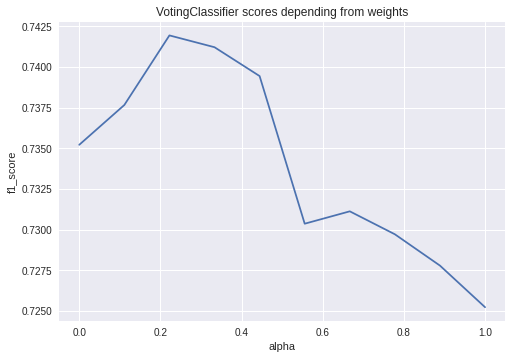

In [35]:
plt.plot(np.linspace(0., 1., 10), mix_clf_scores)
plt.xlabel('alpha')
plt.ylabel('f1_score')
plt.title('VotingClassifier scores depending from weights')